In [1]:
#Inspired by https://www.kaggle.com/cfrazier91/arima-philly-violent-crime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import plotly.plotly as py
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
sns.set_palette([ "#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b"])

/Users/Jason/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
shooting_data=pd.read_csv("Rochester_Shooting_Victims.csv")
homicide_data =pd.read_csv("RochesterNY_Homicides.csv")
all_crime_data=pd.read_csv("RPD__Part_I_Crime_2011_to_Present.csv")

In [3]:
shooting_data.columns

Index([u'X', u'Y', u'ObjectID', u'ID', u'Case_Number', u'Address',
       u'Occurred_Date', u'Occurred_Month', u'Occurred_Year', u'Crime_Type',
       u'Multiple_Shooting', u'Gender', u'Race', u'Ethnicity', u'Victim_Age',
       u'Victim_Age_Band', u'Zipcode'],
      dtype='object')

In [4]:
shooting_data.rename({"ObjectID": "OBJECTID","Address":"Geocode_Address","Occurred_Date":"Date","Occurred_Month":"Month",
                     "Occurred_Year":"Year"}, 
                     axis='columns', inplace=True)

In [5]:
homicide_data.columns

Index([u'X', u'Y', u'OBJECTID', u'Id', u'CaseNumber', u'OccurredDate',
       u'OccurredMonth', u'OccurredYear', u'DateOfDeath', u'DateOfDeathMonth',
       u'DateOfDeathYear', u'DateDifference', u'CaseStatus', u'Address',
       u'Latitude', u'Longitude', u'Section', u'Beat', u'WeaponCategory',
       u'VictimCount', u'ArresteeCount', u'Zipcode'],
      dtype='object')

In [6]:
homicide_data.rename({"Id": "ID","CaseNumber":"Case_Number","CaseStatus":"Case_Status","Address":"Geocode_Address",
                     "Section":"Patrol_Section","Beat":"Geo_Beat","OccurredDate":"Occurred_Date","DateOfDeath":"Date",
                     "DateOfDeathMonth":"Month","DateOfDeathYear":"Year"}, 
                     axis='columns', inplace=True)

In [7]:
all_crime_data.columns

Index([u'X', u'Y', u'OBJECTID', u'Geocode_Address', u'Geocode_Street',
       u'Case_Number', u'OccurredFrom_Date_Year', u'OccurredFrom_Date_Month',
       u'OccurredFrom_Time', u'OccurredFrom_Timestamp',
       u'OccurredThrough_Date_Year', u'OccurredThrough_Date_Month',
       u'OccurredThrough_Time', u'OccurredThrough_Timestamp',
       u'Reported_Date_Year', u'Reported_Date_Month', u'Reported_Time',
       u'Reported_Timestamp', u'Address_StreetFull', u'Address_City',
       u'Address_State', u'Patrol_Beat', u'Patrol_Section', u'Case_Status',
       u'Statute_Title', u'Statute_Section', u'Statute_Subsection',
       u'Statute_Degree', u'Statute_Class', u'Statute_Category',
       u'Statute_Text', u'Statute_Description', u'Statute_CrimeCategory',
       u'Statute_Attempted', u'Weapon_Description', u'Larceny_Type',
       u'Location_Type', u'Geo_Beat', u'Geo_Section', u'Geo_Section_Num'],
      dtype='object')

In [8]:
all_crime_data["Date"]=all_crime_data.OccurredFrom_Timestamp

In [9]:
all_crime_data["Month"]=all_crime_data.OccurredFrom_Date_Month

In [10]:
all_crime_data["Year"]=all_crime_data.OccurredThrough_Date_Year

In [11]:
frames = [all_crime_data, shooting_data, homicide_data]
#combine all 3 datasets
result = pd.concat(frames)

In [12]:
result.index=pd.DatetimeIndex(result.Date)

In [13]:
#filter data to the ones from 2011 only because the largest dataset (all_crime_data) do not have record before 2011
all_crimes_from2011=result[result.index>=np.datetime64('2011-01-01')]

Text(0,0.5,u'Number of crimes')

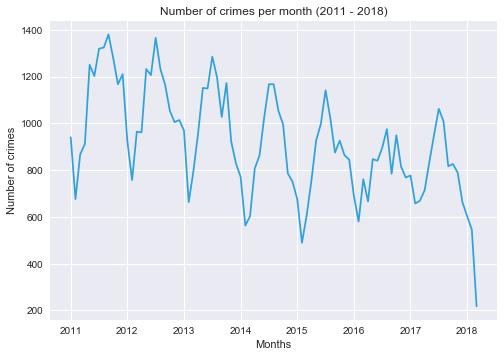

In [14]:
all_crimes_from2011.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2011 - 2018)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')

In [15]:
all_crimes_from2011_monthly_count=pd.DataFrame(all_crimes_from2011.resample('M').size(),columns=['count'])

In [16]:
all_crimes_2011to2016=all_crimes_from2011_monthly_count[all_crimes_from2011_monthly_count.index<np.datetime64('2017-01-01')]

In [17]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#grid search

In [18]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(all_crimes_2011to2016,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:919.902452863
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:584.292911926
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:719.192297948
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:696.989194936
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:595.518297648
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:585.850828386
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1084.96395682
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:844.173436926
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:707.106280663
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:562.811026734
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:712.20847725
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:682.504246287
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:588.192367798
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:564.732350795
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:714.572002016
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:558.703107317
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:708.690091321
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:697.434136616
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:573.796333521
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 -

In [20]:
mod = sm.tsa.statespace.SARIMAX(all_crimes_2011to2016,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7165      0.107     -6.727      0.000      -0.925      -0.508
ma.S.L12      -0.7007      0.287     -2.440      0.015      -1.263      -0.138
sigma2      7144.7948   2228.536      3.206      0.001    2776.945    1.15e+04


In [21]:
#The summary attribute that results from the output of SARIMAX returns a significant amount of information, 
#but we'll focus our attention on the table of coefficients. The coef column shows the weight 
#(i.e. importance) of each feature and how each one impacts the time series. 
#The P>|z| column informs us of the significance of each feature weight. 
#Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

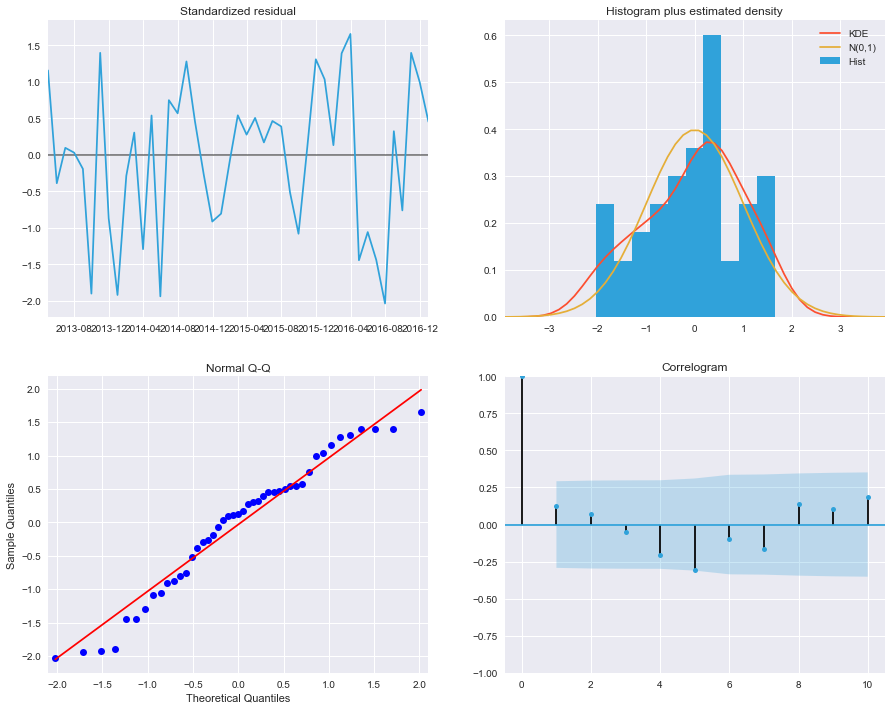

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

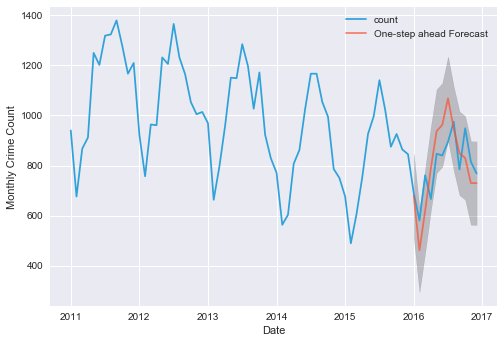

In [24]:
ax = all_crimes_2011to2016['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')
plt.legend()

plt.show()

In [25]:
#Overall, our forecasts align with the true values very well, showing an overall increase trend.

In [26]:
y_forecasted = pred.predicted_mean
y_truth = all_crimes_from2011_monthly_count['2016-01-31':]

In [27]:
# Compute the mean square error
mse = ((y_forecasted - y_truth['count']) ** 2).mean()
RMSE=np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))

The Root Mean Squared Error of our forecasts is 104.28


In [28]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

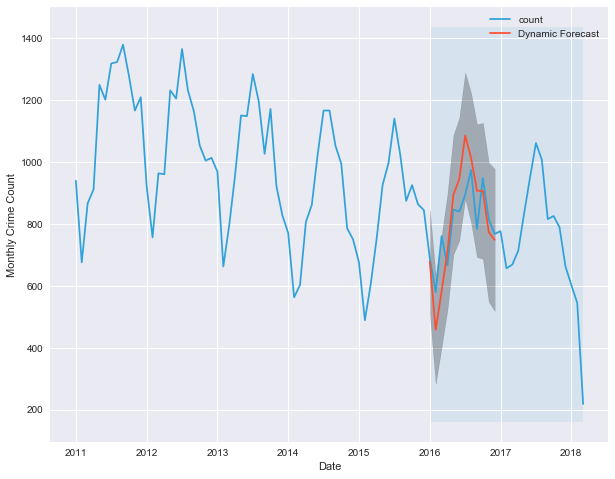

In [29]:
ax = all_crimes_from2011_monthly_count['2011':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-31'), all_crimes_from2011_monthly_count.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()

In [30]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = all_crimes_from2011_monthly_count['2016-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth['count']) ** 2).mean()
RMSE=np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(RMSE, 2)))

The Root Mean Squared Error of our forecasts is 99.8


In [31]:
# Get forecast 12 months ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

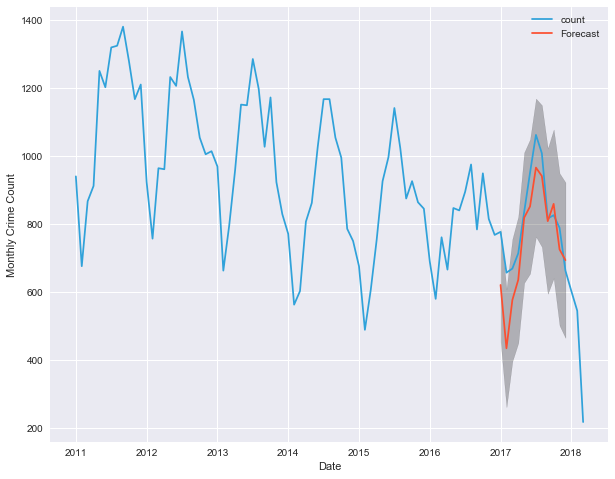

In [32]:
ax = all_crimes_from2011_monthly_count.plot(label='observed', figsize=(10, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()

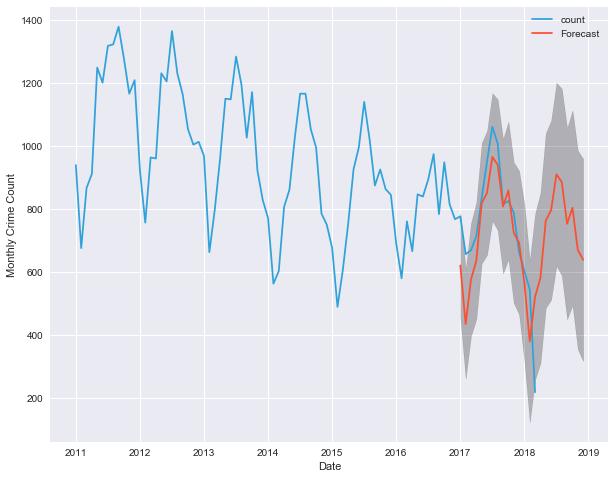

In [33]:
# Get forecast 24months ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = all_crimes_from2011_monthly_count.plot(label='observed', figsize=(10, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Crime Count')

plt.legend()
plt.show()